<a href="https://colab.research.google.com/github/Jaswanthi30/machine-learning/blob/main/JASWANTHI_ABEX_WORK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, classification_report, precision_recall_curve, auc
)

In [3]:
# Load datasets
data_train = pd.read_csv("train.csv")  # Replace with actual dataset
data_test = pd.read_csv("test.csv")    # Replace with actual dataset

In [4]:
# Drop unnecessary columns
drop_columns1 = ["company_name", "last_funding_date", "hiring_roles"]
train_data = data_train.drop(columns=drop_columns1, errors="ignore")
test_ids = data_test["company_id"]  # Store for submission
test_data = data_test.drop(columns=drop_columns1, errors="ignore")

In [5]:
# Handle categorical variables
categorical_features = ["industry"]
encode = LabelEncoder()
for col in categorical_features:
    train_data[col] = encode.fit_transform(train_data[col])
    test_data[col] = encode.transform(test_data[col])

In [6]:
# Select only numeric columns for median imputation
numeric_columns = train_data.select_dtypes(include=[np.number]).columns

# Fill missing values only for numeric columns
train_data[numeric_columns] = train_data[numeric_columns].fillna(train_data[numeric_columns].median())
test_data[numeric_columns] = test_data[numeric_columns].fillna(train_data[numeric_columns].median())  # Use train's median for test

In [7]:
from sklearn.preprocessing import StandardScaler

# Replace infinite values with NaN (to be handled next)
train_data.replace([np.inf, -np.inf], np.nan, inplace=True)
test_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with median (only for numerical columns)
numeric_columns = train_data.select_dtypes(include=[np.number]).columns
train_data[numeric_columns] = train_data[numeric_columns].fillna(train_data[numeric_columns].median())
test_data[numeric_columns] = test_data[numeric_columns].fillna(train_data[numeric_columns].median())  # Use train's median for test

# Feature Scaling
scaler = StandardScaler()
num_features = train_data.drop(columns=["is_hot_lead", "company_id"]).columns

# Apply scaling
train_data[num_features] = scaler.fit_transform(train_data[num_features])
test_data[num_features] = scaler.transform(test_data[num_features])


In [8]:
# Separate features and target
X = train_data.drop(columns=["is_hot_lead", "company_id"])
y = train_data["is_hot_lead"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [9]:
# Hyperparameter tuning for XGBoost
xgb_params = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0]
}
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb1 = RandomizedSearchCV(xgb, xgb_params, cv=3, n_iter=10, scoring="f1", n_jobs=-1, random_state=42)
xgb1.fit(X_train, y_train)
best_xgb = xgb1.best_estimator_

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:46:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [10]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=7, class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=7, n_estimators=200,
                       random_state=42)

In [11]:
# Ensemble Model (Voting Classifier)
voting_clf = VotingClassifier(estimators=[("rf", rf), ("xgb", best_xgb)], voting="soft")
voting_clf.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:46:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=7,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            fea...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                 voting='soft')

In [12]:
# Evaluate model
y_pred = voting_clf.predict(X_val)
y_proba = voting_clf.predict_proba(X_val)[:, 1]  # Probability scores

In [13]:
# Advanced Metrics
print(f"F1-Score: {f1_score(y_val, y_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
print(f"Precision: {precision_score(y_val, y_pred):.4f}")
print(f"Recall: {recall_score(y_val, y_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_val, y_proba):.4f}")

F1-Score: 0.8904
Accuracy: 0.9647
Precision: 0.8304
Recall: 0.9598
ROC-AUC Score: 0.9869


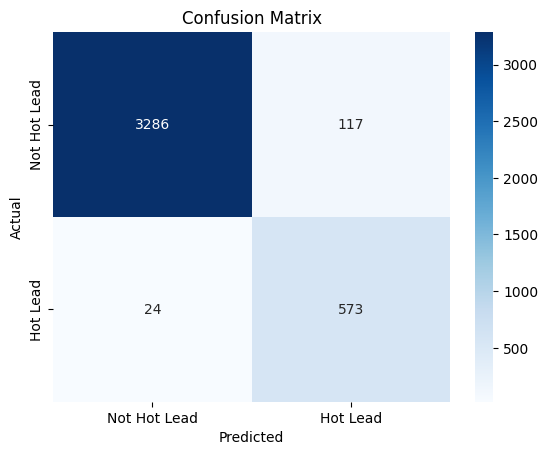

In [14]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Hot Lead", "Hot Lead"], yticklabels=["Not Hot Lead", "Hot Lead"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [15]:
# Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_val, y_proba)
pr_auc = auc(recall, precision)
print(f"PR-AUC Score: {pr_auc:.4f}")

PR-AUC Score: 0.8827


In [16]:
# Classification Report
print("\nClassification Report:\n", classification_report(y_val, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      3403
           1       0.83      0.96      0.89       597

    accuracy                           0.96      4000
   macro avg       0.91      0.96      0.93      4000
weighted avg       0.97      0.96      0.97      4000



In [17]:
# Drop 'is_hot_lead' column from test_data only if it exists
features_to_drop = ["company_id", "is_hot_lead"] if "is_hot_lead" in test_data.columns else ["company_id"]

# Ensure the test data contains only features used during training
test_features = test_data.drop(columns=features_to_drop)

# Make predictions
test_predictions = voting_clf.predict(test_features)


In [18]:
# Create submission file
submission = pd.DataFrame({"company_id": test_ids, "is_hot_lead": test_predictions})
submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")

Submission file saved as submission.csv


In [19]:
import pandas as pd

train_data = pd.read_csv("train.csv")  # Load your training dataset
test_data = pd.read_csv("test.csv")    # Load your test dataset

print(f"Train Data Shape: {train_data.shape}")  # (rows, columns)
print(f"Test Data Shape: {test_data.shape}")


Train Data Shape: (20000, 15)
Test Data Shape: (5000, 15)
